In [1]:
#Import pandas, matplotlib.pyplot, and seaborn
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from datetime import datetime
import os
import yfinance as yf
%matplotlib inline

In [2]:
myfold = os.getcwd()

In [3]:
company_list = pd.read_csv(myfold + '/raw_data/Company.csv')

In [4]:
company_list.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6 entries, 0 to 5
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   ticker_symbol  6 non-null      object
 1   company_name   6 non-null      object
dtypes: object(2)
memory usage: 224.0+ bytes


In [5]:
company_tweet = pd.read_csv(myfold + '/raw_data/Company_Tweet.csv')

In [6]:
company_tweet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4336445 entries, 0 to 4336444
Data columns (total 2 columns):
 #   Column         Dtype 
---  ------         ----- 
 0   tweet_id       int64 
 1   ticker_symbol  object
dtypes: int64(1), object(1)
memory usage: 66.2+ MB


In [7]:
company_tweet.shape

(4336445, 2)

In [8]:
company_tweet.head(10)

,tweet_id,ticker_symbol
0,550803612197457920,AAPL
1,550803610825928706,AAPL
2,550803225113157632,AAPL
3,550802957370159104,AAPL
4,550802855129382912,AAPL
5,550802745737768960,AAPL
6,550797494188142592,AAPL
7,550797275786518528,AAPL
8,550797272686923776,AAPL
9,550796617444765696,AAPL


Let's look at number of tweets by ticker_symbol

In [9]:
tweet = pd.read_csv(myfold + '/raw_data/Tweet.csv')

In [10]:
tweet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3717964 entries, 0 to 3717963
Data columns (total 7 columns):
 #   Column       Dtype 
---  ------       ----- 
 0   tweet_id     int64 
 1   writer       object
 2   post_date    int64 
 3   body         object
 4   comment_num  int64 
 5   retweet_num  int64 
 6   like_num     int64 
dtypes: int64(5), object(2)
memory usage: 198.6+ MB


In [11]:
tweet.head(10)

,tweet_id,writer,post_date,body,comment_num,retweet_num,like_num
0,550441509175443456,VisualStockRSRC,1420070457,"lx21 made $10,008 on $AAPL -Check it out! htt...",0,0,1
1,550441672312512512,KeralaGuy77,1420070496,Insanity of today weirdo massive selling. $aap...,0,0,0
2,550441732014223360,DozenStocks,1420070510,S&P100 #Stocks Performance $HD $LOW $SBUX $TGT...,0,0,0
3,550442977802207232,ShowDreamCar,1420070807,$GM $TSLA: Volkswagen Pushes 2014 Record Recal...,0,0,1
4,550443807834402816,i_Know_First,1420071005,Swing Trading: Up To 8.91% Return In 14 Days h...,0,0,1
5,550443808606126081,aaplstocknews,1420071005,Swing Trading: Up To 8.91% Return In 14 Days h...,0,0,1
6,550443809700851716,iknowfirst,1420071005,Swing Trading: Up To 8.91% Return In 14 Days h...,0,0,1
7,550443857142611968,Cprediction,1420071016,Swing Trading: Up To 8.91% Return In 14 Days h...,0,0,1
8,550443857595600896,iknowfirst_br,1420071017,Swing Trading: Up To 8.91% Return In 14 Days h...,0,0,1
9,550443857692078081,Gold_prediction,1420071017,Swing Trading: Up To 8.91% Return In 14 Days h...,0,0,1


Now in order to associate the company with the tweet we can merge comapny_tweet and tweet dataframes 

In [12]:
tweet_combined = tweet.merge(company_tweet, on='tweet_id', how='inner')

In [13]:
tweet_combined.head(10)

,tweet_id,writer,post_date,body,comment_num,retweet_num,like_num,ticker_symbol
0,550441509175443456,VisualStockRSRC,1420070457,"lx21 made $10,008 on $AAPL -Check it out! htt...",0,0,1,AAPL
1,550441672312512512,KeralaGuy77,1420070496,Insanity of today weirdo massive selling. $aap...,0,0,0,AAPL
2,550441732014223360,DozenStocks,1420070510,S&P100 #Stocks Performance $HD $LOW $SBUX $TGT...,0,0,0,AMZN
3,550442977802207232,ShowDreamCar,1420070807,$GM $TSLA: Volkswagen Pushes 2014 Record Recal...,0,0,1,TSLA
4,550443807834402816,i_Know_First,1420071005,Swing Trading: Up To 8.91% Return In 14 Days h...,0,0,1,AAPL
5,550443807834402816,i_Know_First,1420071005,Swing Trading: Up To 8.91% Return In 14 Days h...,0,0,1,TSLA
6,550443808606126081,aaplstocknews,1420071005,Swing Trading: Up To 8.91% Return In 14 Days h...,0,0,1,AAPL
7,550443808606126081,aaplstocknews,1420071005,Swing Trading: Up To 8.91% Return In 14 Days h...,0,0,1,TSLA
8,550443809700851716,iknowfirst,1420071005,Swing Trading: Up To 8.91% Return In 14 Days h...,0,0,1,AAPL
9,550443809700851716,iknowfirst,1420071005,Swing Trading: Up To 8.91% Return In 14 Days h...,0,0,1,TSLA


Let us inspect tweet for any missing values

In [14]:
tweet_combined.isna().sum()

tweet_id             0
writer           55919
post_date            0
body                 0
comment_num          0
retweet_num          0
like_num             0
ticker_symbol        0
dtype: int64

We find that the writer column has a lot of missing values,as we are not planning to use this column and we ignore it.

The post_date is in form seconds since epoch. Covert it to a date object.

In [15]:
tweet_combined['post_date'] = pd.to_datetime(tweet_combined['post_date'], unit='s')

In [16]:
tweet_combined['date'] = pd.to_datetime(tweet_combined['post_date'].dt.date)


In [17]:
tweet_combined.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4336445 entries, 0 to 4336444
Data columns (total 9 columns):
 #   Column         Dtype         
---  ------         -----         
 0   tweet_id       int64         
 1   writer         object        
 2   post_date      datetime64[ns]
 3   body           object        
 4   comment_num    int64         
 5   retweet_num    int64         
 6   like_num       int64         
 7   ticker_symbol  object        
 8   date           datetime64[ns]
dtypes: datetime64[ns](2), int64(4), object(3)
memory usage: 330.8+ MB


We do not need the twitter id any more.

In [18]:
tweet_combined = tweet_combined.drop(['tweet_id'],axis=1)

In [19]:
tweet_combined.head()

,writer,post_date,body,comment_num,retweet_num,like_num,ticker_symbol,date
0,VisualStockRSRC,2015-01-01 00:00:57,"lx21 made $10,008 on $AAPL -Check it out! htt...",0,0,1,AAPL,2015-01-01
1,KeralaGuy77,2015-01-01 00:01:36,Insanity of today weirdo massive selling. $aap...,0,0,0,AAPL,2015-01-01
2,DozenStocks,2015-01-01 00:01:50,S&P100 #Stocks Performance $HD $LOW $SBUX $TGT...,0,0,0,AMZN,2015-01-01
3,ShowDreamCar,2015-01-01 00:06:47,$GM $TSLA: Volkswagen Pushes 2014 Record Recal...,0,0,1,TSLA,2015-01-01
4,i_Know_First,2015-01-01 00:10:05,Swing Trading: Up To 8.91% Return In 14 Days h...,0,0,1,AAPL,2015-01-01


let's get the date of the oldest and the latest twitter post.

In [20]:
old_post_date = tweet_combined['date'].min()
old_post_date

Timestamp('2015-01-01 00:00:00')

In [21]:
latest_post_date = tweet_combined['date'].max()
latest_post_date

Timestamp('2019-12-31 00:00:00')

Let's check the Total number of tweets by ticker symbol

In [22]:
tweets_by_ticker =tweet_combined.ticker_symbol.value_counts()

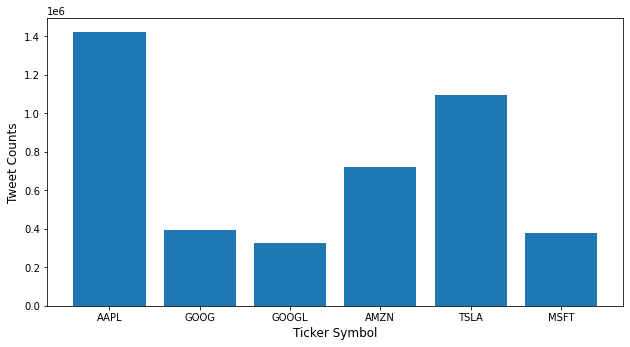

In [23]:
#Bar chart showing the tweets by ticker symbol
fig = plt.figure(figsize=(8,4))
ax = fig.add_axes([0,0,1,1])
ax.set_xlabel("Ticker Symbol",fontsize=12)
ax.set_ylabel("Tweet Counts",fontsize=12)
ticker = company_list['ticker_symbol']
count = tweets_by_ticker[company_list['ticker_symbol']]
ax.bar(ticker,count)
plt.show()

Let's look at the trend of tweets posted over the entire period for these ticker symbols.

In [24]:
tweets_by_month = tweet_combined.groupby(['ticker_symbol', 
                                      tweet_combined['post_date'].dt.to_period("M")]).size().reset_index()
tweets_by_month['post_date'] = tweets_by_month['post_date'].apply(lambda x: pd.to_datetime(str(x)))

In [25]:
tweets_by_month.rename(columns = {0:'tweet_count'},inplace = True)  
            

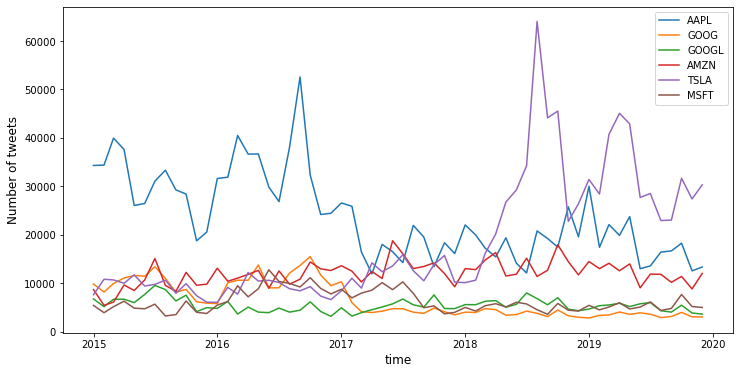

In [26]:
plt.figure(figsize=(12,6))
for ticker_symbol in company_list['ticker_symbol']:
    counts = tweets_by_month[tweets_by_month['ticker_symbol'] == ticker_symbol]
    plt.plot(counts['post_date'],counts['tweet_count'], label=ticker_symbol)

plt.legend()
plt.ylabel('Number of tweets',fontsize=12)
plt.xlabel("time",fontsize=12)
plt.show()  

We will get the historical stock price for all these stocks from yahoo finance

In [27]:
#Install yfinance using pip
!pip install yfinance

In [28]:
# get historical market data
tsla = yf.Ticker("TSLA")

In [29]:

tsla_hist = tsla.history(start=old_post_date, end=latest_post_date)
tsla_hist

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2015-01-02,44.574001,44.650002,42.652000,43.862000,23822000,0,0
2015-01-05,42.910000,43.299999,41.431999,42.018002,26842500,0,0
2015-01-06,42.012001,42.840000,40.841999,42.256001,31309500,0,0
2015-01-07,42.669998,42.956001,41.956001,42.189999,14842000,0,0
2015-01-08,42.562000,42.759998,42.001999,42.124001,17212500,0,0
...,...,...,...,...,...,...,...
2019-12-23,82.356003,84.402000,82.000000,83.844002,66598000,0,0
2019-12-24,83.671997,85.094002,82.538002,85.050003,40273500,0,0
2019-12-26,85.582001,86.695999,85.269997,86.188004,53169500,0,0


Similarly let's get the historical price data for the other stocks.

In [30]:
aapl_hist = yf.Ticker("AAPL").history(start=old_post_date, end=latest_post_date)
msft_hist = yf.Ticker("MSFT").history(start=old_post_date, end=latest_post_date)
googl_hist = yf.Ticker("GOOGL").history(start=old_post_date, end=latest_post_date)
amzn_hist = yf.Ticker("AMZN").history(start=old_post_date, end=latest_post_date)
goog_hist = yf.Ticker("GOOG").history(start=old_post_date, end=latest_post_date)

Now let's visualy analyze to see if there is any trend in volume of a stock traded and the volume of its corresponding tweets on the previous day. Let's get the average of 30 days window for both tweet volume and stock volume to get a feel of the trend.

In [31]:
aapl = tweet_combined[tweet_combined['ticker_symbol'] == 'AAPL']
goog = tweet_combined[tweet_combined['ticker_symbol'] == 'GOOG']
googl = tweet_combined[tweet_combined['ticker_symbol'] == 'GOOGL']
amzn = tweet_combined[tweet_combined['ticker_symbol'] == 'AMZN']
tsla = tweet_combined[tweet_combined['ticker_symbol'] == 'TSLA']
msft = tweet_combined[tweet_combined['ticker_symbol'] == 'MSFT']

In [32]:
def volume_tweet_impact(ticker,stock,title):
    tweet_vol_shift_1 = ticker.groupby(['date']).size().shift(-1).rolling(30).mean().dropna()
    stock_vol = stock['Volume'].rolling(30).mean().dropna()
    fig, ax1 = plt.subplots(figsize=(14, 7))
    ax2 = ax1.twinx()
    ax1.plot(tweet_vol_shift_1.index,tweet_vol_shift_1,color='red',label='Tweet Volume')
    ax2.plot(stock_vol.index,stock_vol,color='green',label='Trade Volume')
    line1, label = ax1.get_legend_handles_labels()
    line2, label2 = ax2.get_legend_handles_labels()
    ax1.legend(line1 + line2, label + label2, loc=0)
    plt.title(title,fontsize=20,color='blue')
    plt.show()

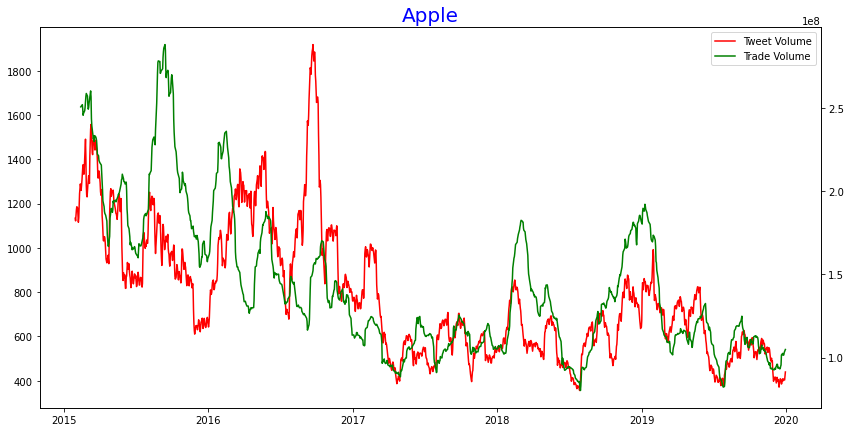

In [33]:
volume_tweet_impact(aapl,aapl_hist,'Apple')

Similarly lets try for Tesla

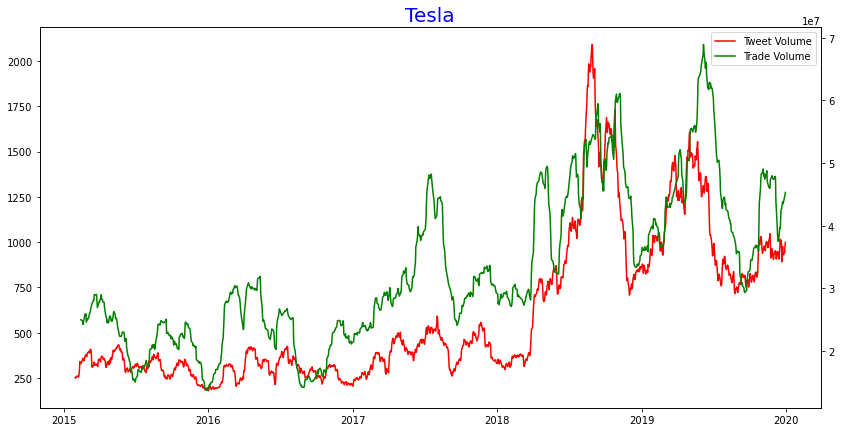

In [34]:
volume_tweet_impact(tsla,tsla_hist,'Tesla')